# Initialization

In [1]:
%run utils.ipynb

In [2]:
field_min_x = 0
field_max_x = 15
field_min_y = 0
field_max_y = 10

points0 = [[1,5],
           [2,2],
           [2,8],
           [4,8],
           [5,1],
           [6,6],
           [10,4],
           [10,6],
           [10,8],
           [12,9],
           [12,1],
           [14,6]]

points1 = [[2,8],
          [10,8],
          [6,6]]

points2 = [[2,8],
          [10,8],
          [6,2],
          [6,4],
          [6,6]]

points3 = [[4,3],[4,6],[4,9],
           [8,3],[8,6],[8,9],
           [12,3],[12,6],[12,9]]

points4 = [[1,1],
          [1,4],
          [4,1],
          [4,4],
          [2,2],
          [3,2]]

In [3]:
import random
rnd_x = sorted([random.random() * 15 for i in range(50)])
rnd_y = [random.random() * 10 for i in range(50)]
points5 = [[x, y] for x, y in zip(rnd_x, rnd_y)]

# Calculation

In [4]:
points = points3

all_lines = points_to_lines(points)
all_intersections = lines_to_intersections(all_lines)
nearest_intersections = get_nearest_intersections(points,
                                                  all_lines,
                                                  all_intersections,
                                                  show=False)
segments = get_line_segments(nearest_intersections, show=False)

*** get_nearest_intersections() ***
Point id: 9 / 9

# Results

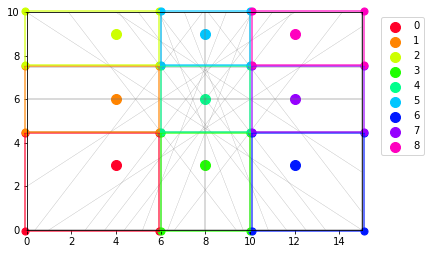

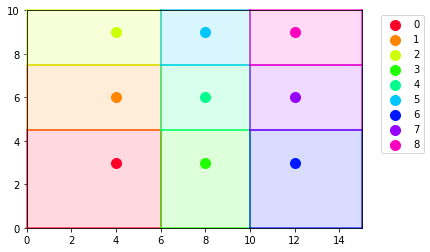

In [5]:
plot(points, all_lines, nearest_intersections, segments)
plot(points, all_lines, nearest_intersections, segments, simple=True, fill=True)

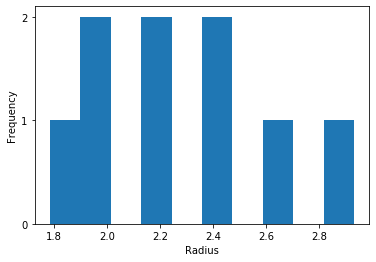

Mean radius     : 2.2776164331782
SD radius       : 0.36377420493661516
Mean log radius : 0.3526675675220445
SD log radius   : 0.06826217953730813


,area,radius,radius_log
0,27.0,2.931615,0.467107
1,18.0,2.393654,0.379061
2,15.0,2.185097,0.339471
3,18.0,2.393654,0.379061
4,12.0,1.954410,0.291016
5,10.0,1.784124,0.251425
6,22.5,2.676186,0.427516
7,15.0,2.185097,0.339471
8,12.5,1.994711,0.299880


In [6]:
#sys.stdout = stdout_backup # print log for get_nearest_intersections()
areas = calculate_areas(nearest_intersections)
areas